In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import *
import tqdm
import string
import random
import os

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, roc_auc_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

In [2]:
### READ DATA ###

df = pd.read_csv('Uber_Ride_Reviews.csv')

print(df.shape)
df.head()

(1344, 3)


ride_review  ride_rating  sentiment
0  I completed running New York Marathon requeste...          1.0          0
1  My appointment time auto repairs required earl...          1.0          0
2  Whether I using Uber ride service Uber Eats or...          1.0          0
3  Why hard understand I trying retrieve Uber cab...          1.0          0
4  I South Beach FL I staying major hotel ordered...          1.0          0

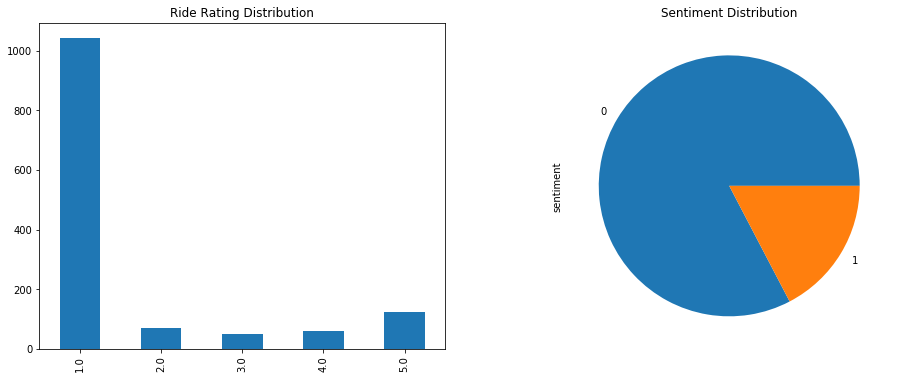

In [3]:
### LABEL DISTRIBUTION ###

plt.figure(figsize=(16,6))

plt.subplot(121)
df.ride_rating.value_counts().sort_index().plot.bar(title='Ride Rating Distribution')

plt.subplot(122)
df.sentiment.value_counts().plot.pie(title='Sentiment Distribution')

In [4]:
### REMOVE 3 STARS REVIEWS ###

df = df.loc[df.ride_rating!=3, :].reset_index(drop=True)

In [5]:
### CLEAN TEXT (NOT REQUIRED) ###

df['text'] = df.ride_review.str.lower().str.replace(r'['+string.digits+string.punctuation+']', ' ')

In [6]:
### TRAIN TEST SPLIT ###

X_train, X_test, y_train, y_test = train_test_split(df['text'], df['sentiment'], random_state=42, test_size=0.2)

In [7]:
### CREATE FEATURES WITH TFIDF ###

stop = set(stopwords.words('english'))
tfidf = TfidfVectorizer(min_df=3, stop_words=stop)
tfidf.fit(X_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=3, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True,
                stop_words={'a', 'about', 'above', 'after', 'again', 'against',
                            'ain', 'all', 'am', 'an', 'and', 'any', 'are',
                            'aren', "aren't", 'as', 'at', 'be', 'because',
                            'been', 'before', 'being', 'below', 'between',
                            'both', 'but', 'by', 'can', 'couldn', "couldn't", ...},
                strip_accents=None, sublinear_tf=False,
                token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                vocabulary=None)

In [8]:
### REVIEWS LENGTH DISTRIBUTION ON TRAIN ###

c = Counter(X_train.apply(lambda x: len(x.split())))
lenghts = np.asarray(list(c.keys()))
freq = np.asarray(list(c.values()))
freq = freq/freq.sum()

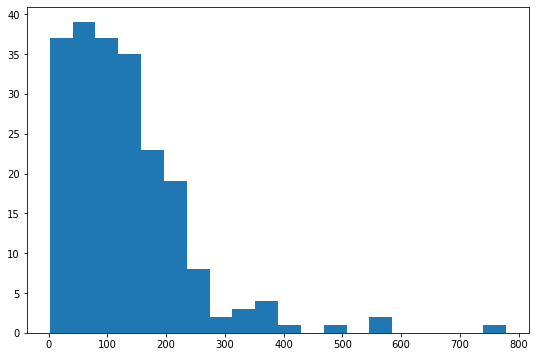

In [9]:
### PLOT REVIEWS LENGTH DISTRIBUTION ON TRAIN ###

plt.figure(figsize=(9,6))
plt.hist(lenghts, bins=20)
np.set_printoptions(False)

In [10]:
### DEFINE MARKOV CHAIN GENERATOR ###

def build_chain(texts):
    
    index = 1
    chain = {}
    
    for text in texts:
        
        text = text.split()
        for word in text[index:]:
            key = text[index-1]
            if key in chain:
                chain[key].append(word)
            else:
                chain[key] = [word]
            index += 1
        
        index = 1
    
    return chain

def create_sentence(chain, lenght, seed):
    
    np.random.seed(seed)
    
    start = random.choice(list(chain.keys()))
    text = [start]

    while len(text) < lenght:
        try:
            after = random.choice(chain[start])
            start = after
            text.append(after)
        except: #end of the sentence
            #text.append('.')
            start = random.choice(list(chain.keys()))
    
    return ' '.join(text)

def Generator(x_train, y_train, rep, concat=False, seed=33):
    
    np.random.seed(seed)
    
    new_corpus, new_labels = [], []
    
    for i,lab in enumerate(np.unique(y_train)):

        selected = x_train[y_train == lab]
        chain = build_chain(selected)

        sentences = []
        for i in range(rep):
            lenght = int(np.random.choice(lenghts, 1, p=freq))
            sentences.append(create_sentence(chain, lenght, seed))

        new_corpus.extend(sentences)
        new_labels.extend([lab]*rep)
    
    if concat:
        return list(x_train) + new_corpus, list(y_train) + new_labels
    
    return new_corpus, new_labels

In [11]:
### AUGMENT TRAIN DATA ###

X_train_new, y_train_new = Generator(X_train, y_train, rep=300, concat=True, seed=33)

In [12]:
pd.value_counts(y_train_new)

0    1195
1     440
dtype: int64

In [13]:
### CREATE FAKE TEST DATA ###

X_test_new, y_test_new = Generator(X_train, y_train, rep=100, concat=False, seed=42)

In [14]:
pd.value_counts(y_test_new)

1    100
0    100
dtype: int64

In [15]:
### UTILITY FUNCTIONS ###


### NN architecture ###
def NN():
    
    nn = Sequential([
              Dense(512, activation='relu', input_shape=(len(tfidf.vocabulary_),)),
              Dropout(0.2),
              Dense(1, activation='sigmoid')
         ], name='keras_nn')
    
    nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return nn


### PERFORMANCE REPORT ###
def report_performances(model, y_test, x_test):
    
    x_test = tfidf.transform(x_test).toarray()
    
    try: #if keras model
        name = nn.name
        pred_class = model.predict_classes(x_test).ravel()
        pred_proba = model.predict_proba(x_test).ravel()
        auc = roc_auc_score(y_test, pred_proba); print('AUC:', auc)
        precision = precision_score(y_test, pred_class, average='weighted'); print('PRECISION:', precision)
        recall = recall_score(y_test, pred_class, average='weighted'); print('RECALL:', recall)
        f1 = f1_score(y_test, pred_class, average='weighted'); print('F1:', f1)
        
    except: #if sklearn model
        pred_class = model.predict(x_test)
        pred_proba = model.predict_proba(x_test)[:,1]        
        auc = roc_auc_score(y_test, pred_proba); print('AUC:', auc)
        precision = precision_score(y_test, pred_class, average='weighted'); print('PRECISION:', precision)
        recall = recall_score(y_test, pred_class, average='weighted'); print('RECALL:', recall)
        f1 = f1_score(y_test, pred_class, average='weighted'); print('F1', f1)

# FIT ON ORIGINAL DATA

In [16]:
tf.random.set_seed(33)
os.environ['PYTHONHASHSEED'] = str(33)
np.random.seed(33)
random.seed(33)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)



nn = NN()
nn.fit(tfidf.transform(X_train).toarray(), np.asarray(y_train), batch_size=32, epochs=5, shuffle=True, verbose=2)

Train on 1035 samples
Epoch 1/5
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
1035/1035 - 1s - loss: 0.4697 - accuracy: 0.8435
Epoch 2/5
1035/1035 - 0s - loss: 0.2885 - accuracy: 0.8647
Epoch 3/5
1035/1035 - 0s - loss: 0.2145 - accuracy: 0.8802
Epoch 4/5
1035/1035 - 0s - loss: 0.1417 - accuracy: 0.9517
Epoch 5/5
1035/1035 - 0s - loss: 0.0815 - accuracy: 0.9836


In [17]:
report_performances(nn, y_test, X_test)

AUC: 0.9112833763996554
PRECISION: 0.8929071270843423
RECALL: 0.8957528957528957
F1: 0.8813293025213556


In [18]:
report_performances(nn, y_test_new, X_test_new)

AUC: 0.9922
PRECISION: 0.9486339348724669
RECALL: 0.945
F1: 0.9448883990079913


In [19]:
logi = LogisticRegression(solver='liblinear', random_state=42)

logi.fit(tfidf.transform(X_train), y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [20]:
report_performances(logi, y_test, X_test)

AUC: 0.9251722652885442
PRECISION: 0.8808604522890237
RECALL: 0.861003861003861
F1 0.8163112563112562


In [21]:
report_performances(logi, y_test_new, X_test_new)

AUC: 0.9717
PRECISION: 0.7604166666666667
RECALL: 0.54
F1 0.4165398274987316


In [22]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)

rf.fit(tfidf.transform(X_train), y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [23]:
report_performances(rf, y_test, X_test)

AUC: 0.875484496124031
PRECISION: 0.8860215901032228
RECALL: 0.8803088803088803
F1 0.8536258274812903


In [24]:
report_performances(rf, y_test_new, X_test_new)

AUC: 0.919
PRECISION: 0.7923976608187135
RECALL: 0.645
F1 0.5938098915872879


# FIT ON ORIGINAL + GENERATED DATA

In [25]:
tf.random.set_seed(33)
os.environ['PYTHONHASHSEED'] = str(33)
np.random.seed(33)
random.seed(33)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)



nn = NN()
nn.fit(tfidf.transform(X_train_new).toarray(), np.asarray(y_train_new), batch_size=32, epochs=5, shuffle=True, verbose=2)

Train on 1635 samples
Epoch 1/5
1635/1635 - 1s - loss: 0.5128 - accuracy: 0.7254
Epoch 2/5
1635/1635 - 1s - loss: 0.2057 - accuracy: 0.9554
Epoch 3/5
1635/1635 - 1s - loss: 0.0643 - accuracy: 0.9914
Epoch 4/5
1635/1635 - 1s - loss: 0.0283 - accuracy: 0.9969
Epoch 5/5
1635/1635 - 1s - loss: 0.0146 - accuracy: 1.0000


In [26]:
report_performances(nn, y_test, X_test)

AUC: 0.9151593453919036
PRECISION: 0.9092574865107055
RECALL: 0.9111969111969112
F1: 0.9019385277737171


In [27]:
report_performances(nn, y_test_new, X_test_new)

AUC: 0.9963000000000001
PRECISION: 0.957240478343885
RECALL: 0.955
F1: 0.9549448073890516


In [28]:
logi = LogisticRegression(solver='liblinear', random_state=42)

logi.fit(tfidf.transform(X_train_new), y_train_new)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [29]:
report_performances(logi, y_test, X_test)

AUC: 0.9162360034453059
PRECISION: 0.8839746754185257
RECALL: 0.8841698841698842
F1 0.8623611134528165


In [30]:
report_performances(logi, y_test_new, X_test_new)

AUC: 0.9791
PRECISION: 0.8571428571428572
RECALL: 0.8
F1 0.7916666666666665


In [31]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)

rf.fit(tfidf.transform(X_train_new), y_train_new)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [32]:
report_performances(rf, y_test, X_test)

AUC: 0.8628337639965546
PRECISION: 0.8755630037870272
RECALL: 0.8841698841698842
F1 0.869182479801949


In [33]:
report_performances(rf, y_test_new, X_test_new)

AUC: 0.9371
PRECISION: 0.83921302578019
RECALL: 0.8
F1 0.7940479868190713
